# Bienvenue au second Workshop PARIS School of AI !

# Neural Networks in Action  : Reconnaître des Panneaux de Signalisation dans une Voiture Autonome

On va apprendre à utiliser un réseaux de neurones pour reconnaître des panneaux de signalisations allemands.

A terme ce projet peut être utiliser pour assister à la conduite ou carrément faire partie du système d'une voiture autonome!

Ce workshop est basé sur le projet suivant : https://github.com/Jeremy26/traffic-signs/blob/master/Traffic_Sign_Classifier.ipynb


![Texte alternatif…](https://chsasank.github.io/assets/images/traffic/classes.jpg)

 ### Avant de commencer!

#### Transférer l'environnement sur GPU!

Clique sur "Execution" dans le menu en haut, et choisi "Modifier le type d'execution." Dans "accélérateur matériel" sélectionne GPU et valide!

C'est partie pour le show!

![Texte alternatif…](https://qph.fs.quoracdn.net/main-qimg-6c7b0c8fda04c655c7ea77baaaf51a33)

#### Vérifier que le dossier Workshop 2 ai bien été ajouté à votre drive!

Tout est dans le titre ;)

#### Comment "Run" une cellule d'un notebook.

Appuie simplement sur Ctrl + Enter pour éxécuter la cellule sélectionnée, ou bien clique sur le petit bouton "Play" à gauche.

Essaie sur la cellule en dessous!


In [13]:
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
import cv2
import os
import csv
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tqdm import tqdm
#print(tf.__version__)


def open_pfile(pfile):
    with open(pfile, mode='rb') as f:
        res = pickle.load(f)
    return res
  
def verification1(X_train, y_train, X_valid, y_valid, X_test , y_test):
    test1 = ((len(X_train)==len(y_train)) and
             (len(X_test)==len(y_test))   and
             (len(X_valid)==len(y_valid)))
    
    test2 = True
    for each in ([X_train, y_train], [X_valid, y_valid], [X_test , y_test]):
        test2 = test2 and each[0].ndim == 4 and each[1].ndim ==1
        
    assert test1, "Erreur: les datasets sont mélangés."
    assert test2, "Erreur: les labels et exemples ont été intervertis."
        
    
    print("Chargement des Dataset réussi.")
    
def show_dataset_split(n_train, n_validation, n_test):
    """ Plot a graph showing how the dataset has been splitted.
    """
    plt.figure()
    sizes = [n_train, n_validation, n_test]
    labels = 'Training', 'Validation', 'Testing'
    colors= ['orange', 'pink', 'cyan']
    explode = (0.01, 0.05, 0.01)  # only "explode" the 2nd slice (i.e. 'Hogs')

    plt.pie(sizes, labels=labels, colors=colors, explode = explode,
            autopct='%1.1f%%',shadow=True, startangle=90)

    plt.show()
    
def show_class_distribution(class_labels):
    """Show the distribution of examples amongst classes."""
    plt.figure(figsize=(10, 4))
    examples_per_class = np.bincount(class_labels)
    num_classes = len(examples_per_class)
    plt.bar(np.arange(num_classes), examples_per_class, 0.8,
            color='#dd1c77', label='Inputs per class')
    plt.xlabel('Class number')
    plt.ylabel('Examples per class')
    plt.title('Distribution of Training Examples Amongst Classes')
    plt.show()   
    

def get_SignName(t_classId):
    with open(os.getcwd()+'/signnames.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if(row['ClassId']==t_classId):
                return row['SignName']

def show_example(exemple, label=None, predi=None, show_now=True):
    """ Show one example with (if provided) ground truth and/or prediction.
    
    parameters :
        exemple : a single example x
        label   : a single label   y
        predi   : the prediction of the neural network.
    """
    
    image = exemple.squeeze()

    plt.figure(figsize=(2,2))
    if show_now : plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    title = ""
    if label is not None:
        label, label_id = get_SignName(str(label)), label
        title += f"Truth : {label_id} : {label}"
    if predi is not None: 
        label, label_id = get_SignName(str(predi)), predi
        title += f"\nPredi : {label_id} : {label}"       
    plt.title(title)

def grayscale(image_data):
    return cv2.cvtColor(image_data, cv2.COLOR_RGB2GRAY)

# Normalisation entre -1 et 1
def normalize_128(image_data):
    return ((image_data - 128.)/128.)


def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.13
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)


    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    #DROPOUT
    hidden_layer_1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(hidden_layer_1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Dropout
    hidden_layer_2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(hidden_layer_2, fc3_W) + fc3_b
    
    return logits

TRAIN_SESSION = -1

def plot_training_curves(training_curves):
    
    train_id = training_curves['training_session']
    epochs_dots = training_curves['epochs']
    training_dots = training_curves['training_accuracy']
    validation_dots = training_curves['validation_accuracy']
    success_dots = training_curves['objective_accuracy']
    
    plt.plot(epochs_dots, training_dots,'b')
    plt.plot(epochs_dots, validation_dots,'go')
    plt.plot(epochs_dots,success_dots,'r')
    plt.title(f'Training and Validation Accuracy for training #{train_id}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def get_neural_net():
    return tf.get_default_session()

def compute_accuracy(neural_net, batch_x, batch_y):
    acc_ops = compute_accuracy.acc_ops
    x = compute_accuracy.x
    y = compute_accuracy.y
    keep_prob = compute_accuracy.keep_prob
    #print(type(batch_x), type(batch_y), type(keep_prob))
    return neural_net.run(acc_ops, 
                          feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})

def get_minibatch(data, offset):
    batch_size = get_minibatch.batch_size
    return data[offset:offset+batch_size]

def split_into_minibatches(X, y, batch_size):
    n = len(X)
    get_minibatch.batch_size = batch_size
    return range(0, n, batch_size)

trainings = []


def ALL_EPOCHS(n_epochs):
    return tqdm(range(n_epochs))

def forward_and_backward_propagation(neural_net, batch_x, batch_y, dropout):
    training_operation = forward_and_backward_propagation.training_operation
    x = forward_and_backward_propagation.x
    y = forward_and_backward_propagation.y
    keep_prob = forward_and_backward_propagation.keep_prob
    #
    neural_net.run(training_operation,
             feed_dict={x: batch_x, y: batch_y,keep_prob:dropout})
    
def test_neural_net(training_session_id, BATCH_SIZE=64):
    confirm = input('Êtes vous sûr.e de vouloir observer le resultat de '
                    'l\'entraînement sur le dataset de Test? [yes/NO]\n')
    
    assert confirm=='yes'
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 32, 32, 1))
    y = tf.placeholder(tf.int32, (None))
    keep_prob = tf.placeholder(tf.float32)
    one_hot_y = tf.one_hot(y, 43)
    logits = LeNet(x, keep_prob)
    
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    compute_accuracy.acc_ops = accuracy_operation
    compute_accuracy.y = y
    compute_accuracy.x = x
    compute_accuracy.keep_prob = keep_prob
    
    with tf.Session() as sess:

        saver = tf.train.import_meta_graph(
            f'./lenet.{training_session_id}.ckpt.meta')
        sess.run(tf.global_variables_initializer())
        saver.restore(sess,  f'./lenet.{training_session_id}.ckpt')
        test_accuracy = evaluate(X_test, y_test, BATCH_SIZE)
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        


print("C'est parfait, continue comme ça!")

C'est parfait, continue comme ça!


### Accéder au contenu de ton Google Drive depuis Collab

Exécute la cellule ci-dessous et suis les instructions qui s'y affichent.

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/Paris School of AI/Shared_SOAI/WORKSHOP_2/")
!ls

Mounted at /content/drive
signnames.csv  test.p  train.p	valid.p  WORKSHOP_2_SOAI.ipynb


### Import du dataset

![Texte alternatif…](https://cdn-images-1.medium.com/max/1600/1*Nv2NNALuokZEcV6hYEHdGA.png)


![Texte alternatif…](https://i.stack.imgur.com/iexkF.png)

In [15]:
""" 
Ici on va ouvrir les fichiers qui contiennent le dataset dans le drive.
Les données ont déjà été splittées en Train, Valid et Test set.

À toi de séparer correctement les Exemples des Labels dans ces data set.
"""

exemples = 'features'
labels   = 'labels'

# Chargement des fichiers qui contiennent le dataset
train_set = open_pfile('train.p')
valid_set = open_pfile('valid.p')
test_set  = open_pfile('test.p')
   
# Ici on sépare les Exemples, des Labels.
# Place les variables, `exemples` et `labels` au bon endroit.

 #TODO
X_train = train_set[exemples]
y_train = train_set[labels]

X_valid = valid_set[exemples]
y_valid = valid_set[labels]

X_test = test_set[exemples]
y_test = test_set[labels]
#ENDTODO

verification1(X_train, y_train, X_valid, y_valid, X_test , y_test)

Chargement des Dataset réussi.


### Data Exploration




#### Fonctions utiles pour cette partie.

In [0]:
len??

In [0]:
np.unique??

In [0]:
# Dans la documentation suivante, recherche l'attibut shape.
np.ndarray??

#### A toi de coder

In [32]:
""" A TOI DE CODER!

OBJECTIF: 

Remplace chaque ellipsis (a.k.a. '...') par la variable qui fait le taf.

Voici les variables dont on dispose à présent:

X_train : (list) Exemples du Train Set
X_valid : (list) Exemples du Validation Set
X_test  : (list) Exemples du Test Set
y_train : (list) Labels du Train Set
y_valid : (list) Labels du Validation Set
y_test  : (list) Labels du Test Set
"""

#TODO : remove triple quotes.
# Le nombre d'exemples dans le Train Set.
n_train       = len(X_train)

# Le nombre d'exemples dans le Validation Set.
n_valid  = len(X_valid)

# Le nombre d'exemples dans le Test Set.
n_test        = len(X_test)

# Le nombre de types de panneaux de signalisation à identifier.
# Ex: S'il n'y avait que deux types de panneaux, (par exemple "Stop" et interdit)
#     `n_classes` vaudrait 2.
n_classes     = len(np.unique(y_train))

# La `shape` de chaque exemple du dataset.
example_shape = X_train[0].shape

print("Number of training examples   =   ", n_train)
print("Number of validation examples =   ", n_valid)
print("Number of testing examples    =   ", n_test)
print("Number of classes             =   ", n_classes)
print("Image data shape              =   ", example_shape)
# ENDREMOVE

Number of training examples   =    34799
Number of validation examples =    4410
Number of testing examples    =    12630
Number of classes             =    43
Image data shape              =    (32, 32, 3)


**Train/Test/Validation**

*   Élément de liste
*   Élément de liste


Le Dataset est splitté en 3 sous-datasets

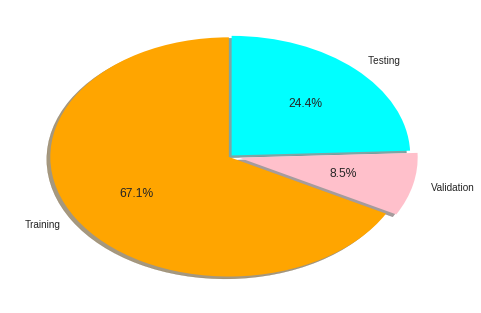

In [33]:
show_dataset_split(n_train, n_valid, n_test)

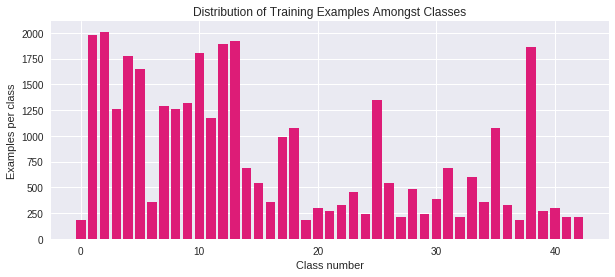

In [34]:
show_class_distribution(y_train)

Unbalanced Dataset !

### Exploration d'une image, Acces au Label
**Apprentissage Supervisé : Image / Label**

In [0]:
index_show = 100

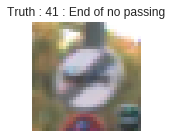

In [29]:
show_example(exemple=X_train[index_show], label=y_train[index_show])

### Preprocessing

In [0]:
def preprocessing(X_train, X_valid, X_test,
                  n_train, n_valid, n_test):
    """Convert Exemples to greyscale and normalize by 128.
    
    return: X_train, X_valid, X_test
    """
    if(X_train.shape != (n_train, 32,32,1)):
        print("Preprocessing X_train...")
        X_train = [grayscale(X_train[i]).reshape(32,32,1) 
                            for i in range(len(X_train))]
        X_train = [normalize_128(img) for img in X_train]
        X_train = np.array(X_train)

    if(X_valid.shape != (n_valid, 32,32,1)):
        print("Preprocessing X_valid...")
        X_valid = [grayscale(X_valid[i]).reshape(32,32,1)  
                            for i in range(len(X_valid))]
        X_valid = [normalize_128(img) for img in X_valid]
        X_valid = np.array(X_valid)

    if(X_test.shape != (n_test, 32,32,1)):
        print("Preprocessing X_test...")
        X_test  = [grayscale(X_test[i]).reshape(32,32,1)  
                            for i in range(len(X_test))]
        X_test  = [normalize_128(img) for img in X_test]
        X_test  = np.array(X_test)
        
    return X_train, X_valid, X_test


Preprocessing X_train...
Preprocessing X_valid...
Preprocessing X_test...


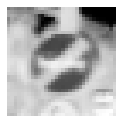

In [35]:
X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test,
                                         n_train, n_valid, n_test)


show_example(X_train[index_show])

In [0]:
shuffle??

In [0]:
## Shuffle 
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)

### Architecture du Réseau de Neurones

**Le Net**


![Texte alternatif…](https://www.researchgate.net/profile/Yann_Lecun/publication/220320307/figure/download/fig1/AS:305682390765571@1449891769454/Architecture-of-convolutional-network-used-for-training-This-represents-one-slice-of-the.png)

### Entraînement

**Learning Rate**

![Texte alternatif…](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/5840d0aa_gradient-descent-convergence/gradient-descent-convergence.gif)
Ideal
![Texte alternatif…](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/5840d077_gradient-descent-divergence/gradient-descent-divergence.gif)
Trop élevé



**Dropout**

![Texte alternatif…](https://camo.githubusercontent.com/06e05aa7d7cd9803221f4a7f0c113aa0bf6a97b4/68747470733a2f2f7777772e64726f70626f782e636f6d2f732f347a36646636656a393075687935352f64726f706f75742e706e673f7261773d31)

In [0]:
###############################################################################      
###############################################################################
###############################################################################      
###############################################################################
#################             EVALUATION FUNCTION            ##################
###############################################################################      
###############################################################################
###############################################################################      
###############################################################################
""" 
Ici on veut calculer la précision d'un réseau de neurone sur l'ensemble des 
données qu'on lui fournit dans `X_data` et `y_data`.

On lui transmet également la taille des batchs pour faciliter le calcul.

La précision correspond à la formule suivante

NOMBRE DE PREDICTIONS CORRECTES diviser par NOMBRE DE PREDICTIONS EFFECTUES

Comme il y a une prediction par exemple, il y a autant de predictions que 
d'exemples dans le set.
"""


def evaluate(X_data, y_data, BATCH_SIZE):
    """ Evalue la qualité du réseau de neurone sur les données 
    `X_data` et `y_data`. 
    """
    # On initialise la variable qui va nous permettre de garder le score
    # ..sur tout le dataset.
    total_score = 0
    # On a besoin du nombre total d'exemples.
    total_number_of_examples = len(X_data)
    # Ici on récupère le réseau de neurone
    neural_net = get_neural_net()
    # Maintenant on découpe le dataset en mini batch.
    for minibatch in split_into_minibatches(X_data, y_data, BATCH_SIZE):
        # Ensuite on va calculer la précision pour chaque minibatch.
        
        # 1. Obtenir le minibatch d'exemples et les labels qui lui correspondent.
        batch_x = get_minibatch(X_data, minibatch)
        batch_y = get_minibatch(y_data, minibatch)
        # 2. Calculer la précision sur le minibatch.
        mini_batch_accuracy = compute_accuracy(neural_net, batch_x, batch_y)
        # 3. Obtenir le nombre d'exemples dans ce minibatch.
        minibatch_size = len(batch_x)
        # 4. Calculer le score obtenu sur le minibatch et l'ajouter au compteur.
        total_score += mini_batch_accuracy * minibatch_size
        # Répeter 1. à 4. pour tous les mini batchs.
        
    # La précision sur l'ensemble des exemples peut maintenant être calculer.    
    total_accuracy = total_score / total_number_of_examples
    # Retourner le résultat.
    return total_accuracy



###############################################################################      
###############################################################################
###############################################################################      
###############################################################################
#################      END OF EVALUATION FUNCTION            ##################
###############################################################################      
###############################################################################
###############################################################################      
###############################################################################


In [0]:
def train_neural_net(X_train, y_train, X_valid, y_valid,
                     n_epochs=20, batch_size=64, dropout=0.5,
                     learning_rate=0.001):
    """ Entraîne un réseau de neurone sur les données `X_train` et `y_train`.
    On se sert des données `X_valid` et `y_valid` comme données de validation.
    
    Le réseau sera entraîné durant `n_epochs`, pour accéler le processus,
    les données sots découpés en lots de taille `batch_size`.
    
    Pour renforcer la généralisation du réseau il sera entraîné avec un handicap
    défini par le paramètre `dropout`.
    
    La vitesse d'apprentissage est défini par le paramètre `learning_rate`.
    """
    
    
    tf.reset_default_graph()
    EPOCHS = n_epochs
    BATCH_SIZE = batch_size
    rate = learning_rate
    x = tf.placeholder(tf.float32, (None, 32, 32, 1))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, 43)
    keep_prob = tf.placeholder(tf.float32)
    logits = LeNet(x, keep_prob)
    cross_entropy      = tf.nn.softmax_cross_entropy_with_logits_v2(
                                                        labels=one_hot_y,
                                                        logits=logits)
    loss_operation     = tf.reduce_mean(cross_entropy)
    optimizer          = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    compute_accuracy.acc_ops = accuracy_operation
    compute_accuracy.y = y
    compute_accuracy.x = x
    compute_accuracy.keep_prob = keep_prob
    
    forward_and_backward_propagation.training_operation = training_operation
    forward_and_backward_propagation.x = x
    forward_and_backward_propagation.y = y
    forward_and_backward_propagation.keep_prob = keep_prob
    
    with tf.Session() as neural_net:
        sess = neural_net
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)
        validation_dots = []
        training_dots = []
        epochs_dots = []
        success_dots = []
        
        
        
###############################################################################      
###############################################################################
###############################################################################      
###############################################################################
#################              THE TRAINING LOOP             ##################
###############################################################################      
###############################################################################
###############################################################################      
###############################################################################
        """ Bienvenue dans la boucle d'entraînement. 
        C'est ici que le réseau apprend petit à pétit à donner un sens aux 
        données qu'on lui donne.
        """
        # Cette boucle va être répetée pour plusieurs epochs.
        for every_epoch in ALL_EPOCHS(n_epochs):
            # 1. On mélange les données de façon à ne pas toujours montrer les
            # exemples dans le même ordre à notre réseau.
            X_train, y_train = shuffle(X_train, y_train)
            
            # 2. On découpe les données d'entrainement en plusieurs batchs.
            for minibatch in split_into_minibatches(X_train, y_train, BATCH_SIZE):

                batch_x = get_minibatch(X_train, minibatch)
                batch_y = get_minibatch(y_train, minibatch)

                # 3. Pour chaque minibatch
                forward_and_backward_propagation(neural_net, 
                                                 batch_x,
                                                 batch_y, 
                                                 dropout)
        
            # 4. L'Epoch est révolu, maintenant on évalue la qualité de 
            #    l'entraînement du réseau pour l'epoch présente.
            #    On va garder ces informations pour afficher des courbes qui 
            #    nous permettront de developper notre intuition sur le d
            #    déroulement de l'entraînement.
            validation_accuracy = evaluate(X_valid,y_valid, BATCH_SIZE)        
            training_accuracy   = evaluate(X_train, y_train, BATCH_SIZE)
              
###############################################################################      
###############################################################################
###############################################################################      
###############################################################################
#################      END OF  THE TRAINING LOOP             ##################
###############################################################################      
###############################################################################
###############################################################################      
###############################################################################            
            training_dots.append(training_accuracy)
            validation_dots.append(validation_accuracy)
            i = every_epoch
            epochs_dots.append(i)
            success_dots.append(0.93)
        test_accuracy = evaluate(X_test,y_test,BATCH_SIZE)    
        saver = tf.train.Saver()
        global TRAIN_SESSION 
        TRAIN_SESSION = TRAIN_SESSION + 1
        save_name = f'./lenet.{TRAIN_SESSION}.ckpt'
        saver.save(sess, save_name )
        print(f"\nModel saved, this was training session #{TRAIN_SESSION}")
    
    return {'training_session' : TRAIN_SESSION + 0,
            'epochs': epochs_dots, 
            'test_accuracy':test_accuracy,
            'validation_accuracy': validation_dots, 
            'training_accuracy': training_dots,
            'objective_accuracy': success_dots}

In [47]:
training_curves = train_neural_net(X_train,y_train,X_valid,y_valid,
                                   n_epochs=30, batch_size=32, dropout=0.5,learning_rate=1000)

trainings.append(training_curves)

100%|██████████| 30/30 [03:13<00:00,  6.42s/it]



Model saved, this was training session #2


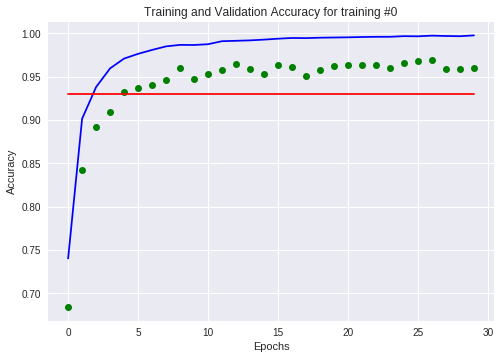

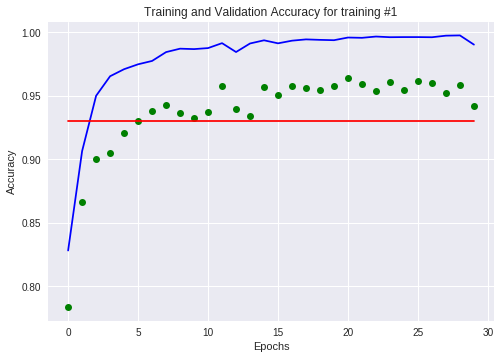

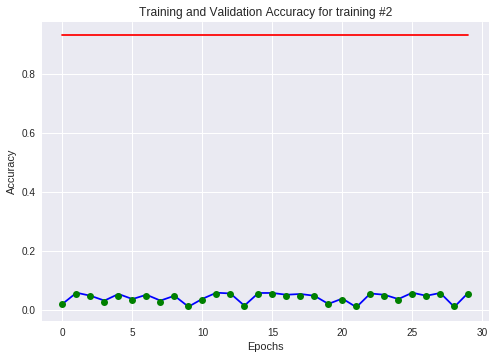

In [48]:
for training in trainings:
    plot_training_curves(training)

### Test

In [53]:
for i in range(len(trainings)):
    print(i, trainings[i]['test_accuracy'])


0 0.9479018211081589
1 0.9327790974343663
2 0.05938242280285035


# NEXT STEPS

NameError: ignored

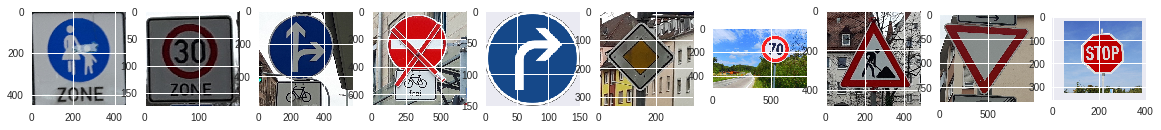

In [0]:
%matplotlib inline

n_images = 10
x_internet_signs = []

def load_images(path):
    sign = mpimg.imread(path)
    #plt.figure(figsize=(2,2))
    x_internet_signs.append(sign)

[load_images("signs/" + new_img) for new_img in os.listdir("signs/")]

f, (ax1, ax2, ax3, ax4,ax5, ax6,ax7,ax8,ax9,ax10) = plt.subplots(1, 10, figsize=(20,10))

x_internet_signs = np.array(x_internet_signs)
ax1.imshow(x_internet_signs[0])
ax2.imshow(x_internet_signs[1])
ax3.imshow(x_internet_signs[2])
ax4.imshow(x_internet_signs[3])
ax5.imshow(x_internet_signs[4])
ax6.imshow(x_internet_signs[5])
ax7.imshow(x_internet_signs[6])
ax8.imshow(x_internet_signs[7])
ax9.imshow(x_internet_signs[8])
ax10.imshow(x_internet_signs[9])

x_internet_signs = np.array(x_internet_signs)
for i in range(len(x_internet_signs)):
    show_image(x_internet_signs[i])

In [0]:
y_output =[]

def fileNames(filename):
    file = os.path.basename(filename)
    classId = file.split(".")[0]
    y_output.append(classId)
    return y_output

[fileNames("signs/" + img) for img in os.listdir("signs/")]

y_output= np.array(y_output)
print(y_output)

['27' '1' '36' '17' '33' '12' '4' '25' '13' '14']


In [0]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

## PREPROCESSING

for i in range(len(x_internet_signs)):
    output_shape = (x_internet_signs[i].shape[0],x_internet_signs[i].shape[1], 1)
    x_internet_signs[i] = grayscale(x_internet_signs[i]).reshape(output_shape) 
    x_internet_signs[i]= cv2.resize(x_internet_signs[i], (32,32))
    x_internet_signs[i]= np.array(x_internet_signs[i]).reshape(32,32,1)

x_internet_signs = [normalize_128(img) for img in x_internet_signs]
x_internet_signs = np.array(x_internet_signs)

In [0]:
y_prediction = np.zeros(n_images)
with tf.Session() as sess:
    saver.restore(sess, './lenet.ckpt')
    #x_internet_signs, y_output = shuffle(x_internet_signs,y_output)
    testing_accuracy = evaluate(x_internet_signs, y_output)
    print("Test Accuracy = {:.3f}".format(testing_accuracy))
    predicted_logits = sess.run(logits, feed_dict={x: x_internet_signs, keep_prob: 1.0})
    softmax = tf.nn.softmax(predicted_logits)
    softmax = sess.run(softmax, feed_dict={logits: predicted_logits})
    y_prediction = np.argmax(softmax, axis=1)
    
    for i in range(0, n_images):
        show_image(x_internet_signs[i].squeeze())
        plt.show()
        print(str(y_prediction[i]) + " --- PREDICTION : " + get_SignName(str(y_prediction[i])) +  " --- ACTUAL CLASS : "+\
              get_SignName(str(y_output[i])))

NameError: ignored

## Challenge : Augmenter le Dataset

Ce challenge vous permet d'aller plus loin dans le réseau de neurones et le dataset.

Améliorez le dataset et partagez les résultats ! Publiez votre code sur Github, les meilleurs résultats (% sur le train/test/validation et potentiellement de nouvelles images) auront une publication sur LinkedIn et Twitter

** Et Maintenant ?**


Les étapes réalisées lors de ce workshop ont été les suivantes : 


1.   **Collecter** un Dataset et le Splitter en 3 sous parties : **entraînement**, **validation**, et **test**
2.   **Explorer** le Dataset pour comprendre les images présentes, la distribution par classe, ...
3.   Réaliser un **préprocessing** sur les images pour les rendre compatibles avec le modèle.
4.   Définir l'**architecture** du réseau de neurones et les **paramètres**
5.    **Entraîner** le réseau de neurones et afficher l'erreur à chaque itération
6    **Tester** le réseau sur de nouvelles images

Le dataset est mal distribué, réaliser de la **Data Augmentation** pour le rendre **équilibré**.

**Comment ?**
Il serait pratique que chaque classe ait le même nombre d'exemples.

**Quelles techniques rapides pour augmenter le nombre d'exemples ?**

On peut recenser quelques techniques : 

 ![Texte alternatif…](https://cdn-images-1.medium.com/max/1020/1*C8hNiOqur4OJyEZmC7OnzQ.png)

![Texte alternatif…](https://cdn-images-1.medium.com/max/1600/1*_mgTLhXwWGDEgz_2C7dRDg.png)



**ATTENTION**
Pour entrer dans le réseau de neurones, chaque image doit etre de dimension (32,32,1); en entraînement ou en test

In [0]:
# TODO : Rotations -- Call cv2.rotate function

## Algorithme example (plus d'une solution est vraie):
# Créer une liste vide
# Séparer le dataset par classes
# Parcourir chaque classe, si la classe à un nombre faible d'exemples :
# Pour chaque image, faire une ou plusieurs rotations (le nombre de rotations dépend du nombre d'images nécessaires)
# Ajouter l'image original et les images pivotées à la liste vide
# Ajouter également le label pour qu'on reste dans de l'apprentissage supervisé

## Nous avons maintenant doublé ou triplé le nombre d'exemples dans une classe

# Refaire un entraînement avec les nouvelles listes X_augmented et Y_augmented
# Noter la différence